In [21]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier

import imodels
from imodels.util import data_util
from imodels.discretization import discretizer, simple

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.dpi'] = 250

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import viz
import validate
# from local_models.stable import StableLinearClassifier as stbl_local
# from experiments.util import get_comparison_result

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None, model_name=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        plt.plot(all_stats['sens'], all_stats['spec'], '.-', label=model_name)
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

In [28]:
class TransferTree:

    def __init__(self, num_groups: int, *args, **kwargs):
        self.trees = [
            DecisionTreeClassifier(*args, **kwargs) for _ in range(num_groups)
        ]

    def fit(self, X, y, sample_weights):
        for tree, weight in zip(self.trees, sample_weights):
            tree.fit(X, y, weight)
        return self

    def predict(self, X, tree_idx):
        return self.trees[tree_idx].predict(X)
    
    def predict_proba(self, X, tree_idx):
        return self.trees[tree_idx].predict_proba(X)

results = defaultdict(lambda:[])
columns = [f'spec9{i}' for i in range(4, 9)] + ['apc', 'auc', 'modelobj']

def log_results(model, model_name, X_test, y_test, tree_idx=None):
    if isinstance(model, TransferTree):
        pred_proba_args = (X_test, tree_idx)
        # tree_0 = model.trees[0]
        # tree_1 = model.trees[1]
    else:
        pred_proba_args = (X_test,)
        # tree_0, tree_1 = model, model
    
    spec_scorer_list = [validate.make_best_spec_high_sens_scorer(sens) for sens in [0.94, 0.95, 0.96, 0.97, 0.98]]
    spec_scores = [scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]) for scorer in spec_scorer_list]
    apc = metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    auc = metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])

    # auc at 90?

    results[model_name] = spec_scores + [apc, auc, model]

    # print('acc: ', metrics.accuracy_score(y_test, model.predict(*pred_proba_args)))
    # print('spec94: ', spec_scores[0])
    # print('spec95: ', spec_scores[1])
    # print('APC: ', apc)
    # print('AUC: ', auc)

    # y_test_0, y_test_1 = y_test[~test_subgroups[1]], y_test[test_subgroups[1]]
    # X_test_0, X_test_1 = X_test[~test_subgroups[1]], X_test[test_subgroups[1]]

    # y_score_0 = tree_0.predict_proba(X_test_0)[:, 1]
    # print('group 0 spec: ', spec_scorer(y_test_0, y_score_0))
    # print('group 0 APC: ', metrics.average_precision_score(y_test_0, y_score_0))
    # print('group 0 AUC: ', metrics.roc_auc_score(y_test_0, y_score_0))

    # y_score_1 = tree_1.predict_proba(X_test_1)[:, 1]
    # print('group 1 spec: ', spec_scorer(y_test_1, y_score_1))
    # print('group 1 APC: ', metrics.average_precision_score(y_test_1, y_score_1))
    # print('group 1 AUC: ', metrics.roc_auc_score(y_test_1, y_score_1))


In [4]:
class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        else:
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

class OCT2019:
    pass

In [5]:
X, y, feature_names = data_util.get_clean_dataset('tbi_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [6]:
def predict_and_save(model, X_test, y_test, model_name=None):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = all_stats_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    # pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

## age split

### training propensity model

In [7]:
# def get_subgroups_age(df, cutoff = 3):
#     max = df['AgeinYears'].max()
#     is_group_1 = df['AgeinYears'] > cutoff
#     p_group_1 = 0.5 / cutoff * df['AgeinYears']
#     p_group_1[is_group_1] = 0.5 / (max - cutoff) * (df.loc[is_group_1, 'AgeinYears'] - cutoff) + 0.5
#     return is_group_1, p_group_1

# is_group_1, p_group_1 = get_subgroups_age(X_df, 2)
# is_group_1_train, is_group_1_test, p_group_1_train, p_group_1_test = model_selection.train_test_split(
#     is_group_1, p_group_1, random_state=2)
# age_groups_test = [~is_group_1_test, is_group_1_test]
# age_groups_train, age_groups_test = zip(*[
#     model_selection.train_test_split(group, random_state=2) for group in age_groups])

In [8]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset('tbi_prop.csv', data_source='imodels', convertna=False)

In [9]:
X_df_prop = pd.DataFrame(X_prop_raw, columns=fnames_prop).drop(columns=['AgeInMonth', 'AgeinYears'])
y_prop = X_df_prop['AgeTwoPlus'].values
X_df_prop = X_df_prop.drop(columns=['AgeTwoPlus'])
X_prop = X_df_prop.values
X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test = model_selection.train_test_split(X_prop, y_prop, test_size=0.2, random_state=3)
X_prop_train, X_prop_val, y_prop_train, y_prop_val = model_selection.train_test_split(X_prop_train_full, y_prop_train_full, test_size=0.2, random_state=3)

In [10]:
# prop_model = LogisticRegressionCV(Cs=5, penalty='elasticnet', max_iter=500, solver='saga', l1_ratios=[0.1, 0.25, 0.5])
# prop_model.fit(X_prop_train, y_prop_train)

In [11]:
prop_model = LogisticRegression(C=1)
prop_model.fit(X_prop_train, y_prop_train)

/Users/keyan/anaconda3/envs/imodels-experiments/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [12]:
print(metrics.roc_auc_score(y_prop_val, prop_model.predict_proba(X_prop_val)[:, 1]))
print(metrics.accuracy_score(y_prop_val, prop_model.predict(X_prop_val)))

0.9489408932518846
0.8946825747532774


(array([ 235.,  568.,  561.,  347.,  190.,  119.,  137.,  153.,  302.,
        4177.]),
 array([6.89520615e-04, 1.00620535e-01, 2.00551549e-01, 3.00482563e-01,
        4.00413577e-01, 5.00344592e-01, 6.00275606e-01, 7.00206620e-01,
        8.00137634e-01, 9.00068648e-01, 9.99999663e-01]),
 <BarContainer object of 10 artists>)

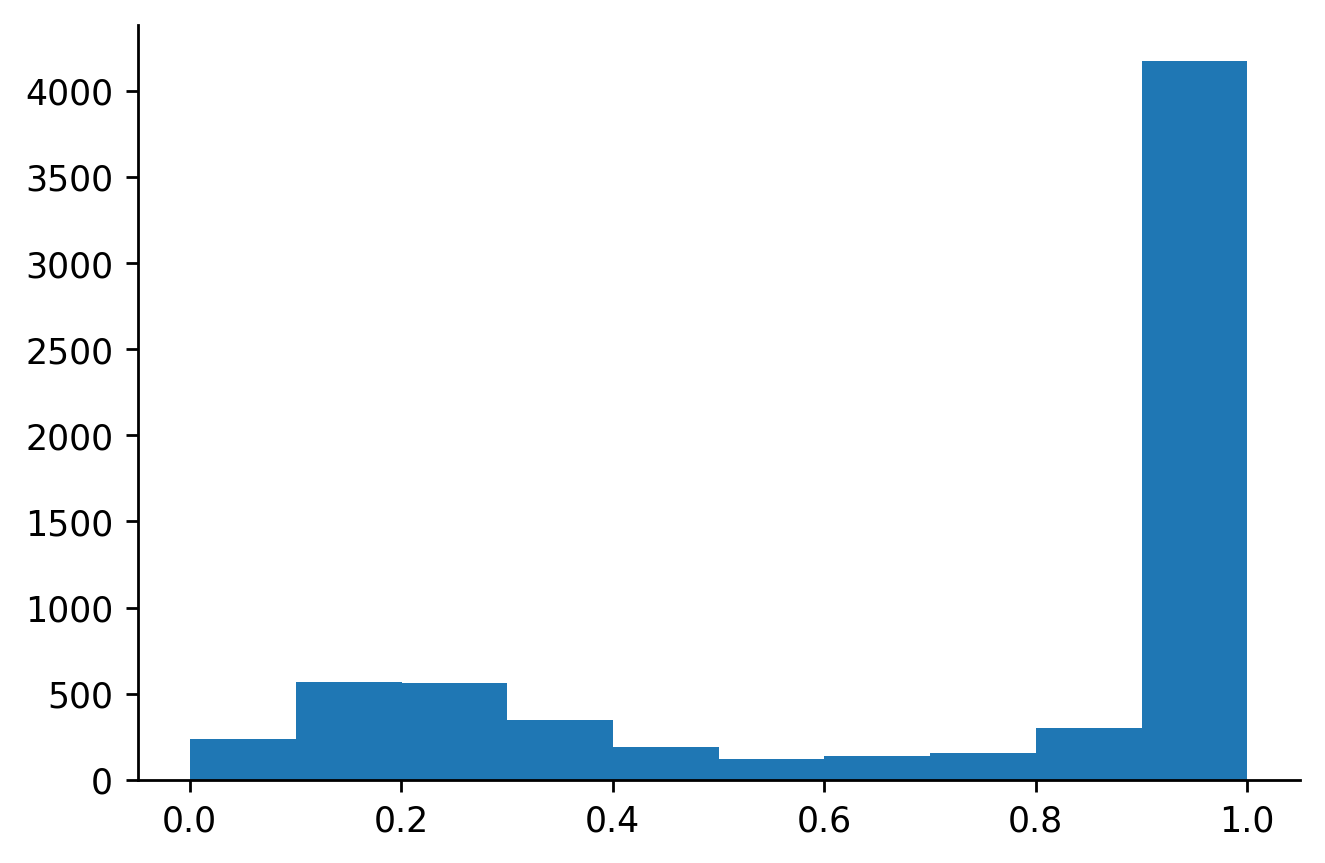

In [13]:
plt.hist(prop_model.predict_proba(X_prop_val)[:, 1])

In [14]:
# prop_model.C_
# prop_model.l1_ratio_

In [15]:
# prop_model_final = LogisticRegression(C=1, l1_ratio=0.5, penalty='elasticnet', solver='saga')
# prop_model_final.fit(X_prop_train_full, y_prop_train_full)

prop_model_final = LogisticRegression(C=1)
prop_model_final.fit(X_prop_train_full, y_prop_train_full)

/Users/keyan/anaconda3/envs/imodels-experiments/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [16]:
prop_scores_group_1 = prop_model_final.predict_proba(X_prop_train_full)[:, 1]

### data setup

In [17]:
is_group_1 = X_df['AgeTwoPlus'].astype(bool)
X_df_clean = X_df.drop(columns=['AgeTwoPlus', 'AgeinYears'])

# X_young, X_old, feature_names = X_df_clean_young.values, X_df_clean_old.values, X_df_clean_young.columns.values

X_train, X_test, y_train, y_test, is_group_1_train, is_group_1_test = (
    model_selection.train_test_split(X_df_clean, y, is_group_1, test_size=0.2, random_state=3))

X_train_young, X_test_young = X_train[~is_group_1_train], X_test[~is_group_1_test]
X_train_old, X_test_old = X_train[is_group_1_train], X_test[is_group_1_test]
y_train_young, y_test_young = y_train[~is_group_1_train], y_test[~is_group_1_test]
y_train_old, y_test_old = y_train[is_group_1_train], y_test[is_group_1_test]

In [18]:
max_leaf_nodes_options = [4, 8, 12, 16]
class_weight_options = [{0: 1, 1: 10}, {0: 1, 1: 100}, {0: 1, 1: 500}]
max_rules_options = [4, 8, 12, 16]

# young_args = {'max_leaf_nodes': 8, 'class_weight': {0: 1, 1: 1000}, 'random_state': 0}
# old_args = {'max_leaf_nodes': 12, 'class_weight': {0: 1, 1: 1000}, 'random_state': 0}

### PECARN

In [22]:
young_pecarn, old_pecarn = PECARNModel(young=True), PECARNModel(young=False)

log_results(young_pecarn, 'PECARN_<2', X_test_young, y_test_young, 0)
log_results(old_pecarn, 'PECARN_>2', X_test_old, y_test_old, 1)

### separate CART

In [23]:
# age_sample_weights_train = [(~is_group_1_train).astype(int), is_group_1_train.astype(int)]
# subcart_no_transfer = TransferTree(2, **dtree_args)
# subcart_no_transfer.fit(X_train, y_train, age_sample_weights_train)
# print_results(subcart_no_transfer, 'CART', X_test, y_test, 0)
# print_results(subcart_no_transfer, 'CART', X_test, y_test, 1)

for mln, cls_weight in itertools.product(max_leaf_nodes_options, class_weight_options):
    young_cart = DecisionTreeClassifier(max_leaf_nodes=mln, class_weight=cls_weight, random_state=0)
    old_cart = DecisionTreeClassifier(max_leaf_nodes=mln, class_weight=cls_weight, random_state=0)

    young_cart.fit(X_train_young, y_train_young)
    old_cart.fit(X_train_old, y_train_old)

    log_results(young_cart, f'CART_<2_{mln}_{cls_weight[1]}', X_test_young, y_test_young, 0)
    log_results(old_cart, f'CART_>2_{mln}_{cls_weight[1]}', X_test_old, y_test_old, 1)

### separate FIGS

In [24]:
for mrules, cls_weight in itertools.product(max_rules_options, class_weight_options):
    young_figs = imodels.FIGSClassifier(max_rules=mrules)
    old_figs = imodels.FIGSClassifier(max_rules=mrules)

    young_figs.fit(X_train_young.values, y_train_young, sample_weight=y_train_young * cls_weight[1] + 1)
    old_figs.fit(X_train_old.values, y_train_old, sample_weight=y_train_old * cls_weight[1] + 1)

    log_results(young_figs, f'FIGS_<2_{mrules}_{cls_weight[1]}', X_test_young.values, y_test_young, 0)
    log_results(old_figs, f'FIGS_>2_{mrules}_{cls_weight[1]}', X_test_old.values, y_test_old, 1)  

### TODO: separate OCT / transfer OCT

### transfer CART

In [25]:
for mln, cls_weight in itertools.product(max_leaf_nodes_options, class_weight_options):
    
    young_tt = DecisionTreeClassifier(max_leaf_nodes=mln, class_weight=cls_weight, random_state=0)
    old_tt = DecisionTreeClassifier(max_leaf_nodes=mln, class_weight=cls_weight, random_state=0)

    young_tt.fit(X_train, y_train, sample_weight=1 - prop_scores_group_1)
    old_tt.fit(X_train, y_train, sample_weight=prop_scores_group_1)

    log_results(young_tt, f'TCART_<2_{mln}_{cls_weight[1]}', X_test_young, y_test_young, 0)
    log_results(old_tt, f'TCART_>2_{mln}_{cls_weight[1]}', X_test_old, y_test_old, 1)

### transfer FIGS

In [26]:
for mrules, cls_weight in itertools.product(max_rules_options, class_weight_options):
    young_tfigs = imodels.FIGSClassifier(max_rules=mrules)
    old_tfigs = imodels.FIGSClassifier(max_rules=mrules)

    young_tfigs.fit(X_train.values, y_train, sample_weight=(1 - prop_scores_group_1) * (y_train * cls_weight[1] + 1))
    old_tfigs.fit(X_train.values, y_train, sample_weight=prop_scores_group_1 * (y_train * cls_weight[1] + 1))

    log_results(young_tfigs, f'TFIGS_<2_{mrules}_{cls_weight[1]}', X_test_young.values, y_test_young, 0)
    log_results(old_tfigs, f'TFIGS_>2_{mrules}_{cls_weight[1]}', X_test_old.values, y_test_old, 1)  

### HPO results

In [32]:
all_results = pd.DataFrame.from_dict(results, orient='index', columns=columns)
young_results = all_results[all_results.index.str.contains('<2')]
young_results.iloc[:, :-1].style.background_gradient()

,spec94,spec95,spec96,spec97,spec98,apc,auc
PECARN_<2,0.549451,0.549451,0.549451,0.549451,0.549451,0.020768,0.774725
CART_<2_4_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.071315,0.775382
CART_<2_4_100,0.000000,0.000000,0.000000,0.000000,0.000000,0.031075,0.800167
CART_<2_4_500,0.000000,0.000000,0.000000,0.000000,0.000000,0.022852,0.718872
CART_<2_8_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.094897,0.833373
CART_<2_8_100,0.000000,0.000000,0.000000,0.000000,0.000000,0.036123,0.833122
CART_<2_8_500,0.000000,0.000000,0.000000,0.000000,0.000000,0.024274,0.752867
CART_<2_12_10,0.000956,0.000956,0.000000,0.000000,0.000000,0.073994,0.784424
CART_<2_12_100,0.000000,0.000000,0.000000,0.000000,0.000000,0.039909,0.754873
CART_<2_12_500,0.000000,0.000000,0.000000,0.000000,0.000000,0.028205,0.775119


In [33]:
old_results = all_results[all_results.index.str.contains('>2')]
old_results.iloc[:, :-1].style.background_gradient()

,spec94,spec95,spec96,spec97,spec98,apc,auc
PECARN_>2,0.583821,0.000000,0.000000,0.000000,0.000000,0.019173,0.765125
CART_>2_4_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.091123,0.768242
CART_>2_4_100,0.000000,0.000000,0.000000,0.000000,0.000000,0.056835,0.780601
CART_>2_4_500,0.000000,0.000000,0.000000,0.000000,0.000000,0.023427,0.742951
CART_>2_8_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.061131,0.798663
CART_>2_8_100,0.000000,0.000000,0.000000,0.000000,0.000000,0.059324,0.818063
CART_>2_8_500,0.587621,0.397499,0.397499,0.000000,0.000000,0.044724,0.825427
CART_>2_12_10,0.000000,0.000000,0.000000,0.000000,0.000000,0.072351,0.802299
CART_>2_12_100,0.037201,0.037201,0.037201,0.037201,0.037201,0.059518,0.824446
CART_>2_12_500,0.000000,0.000000,0.000000,0.000000,0.000000,0.044917,0.821942


### Sensitivity specificity plots

100%|██████████| 122/122 [00:01<00:00, 66.84it/s]


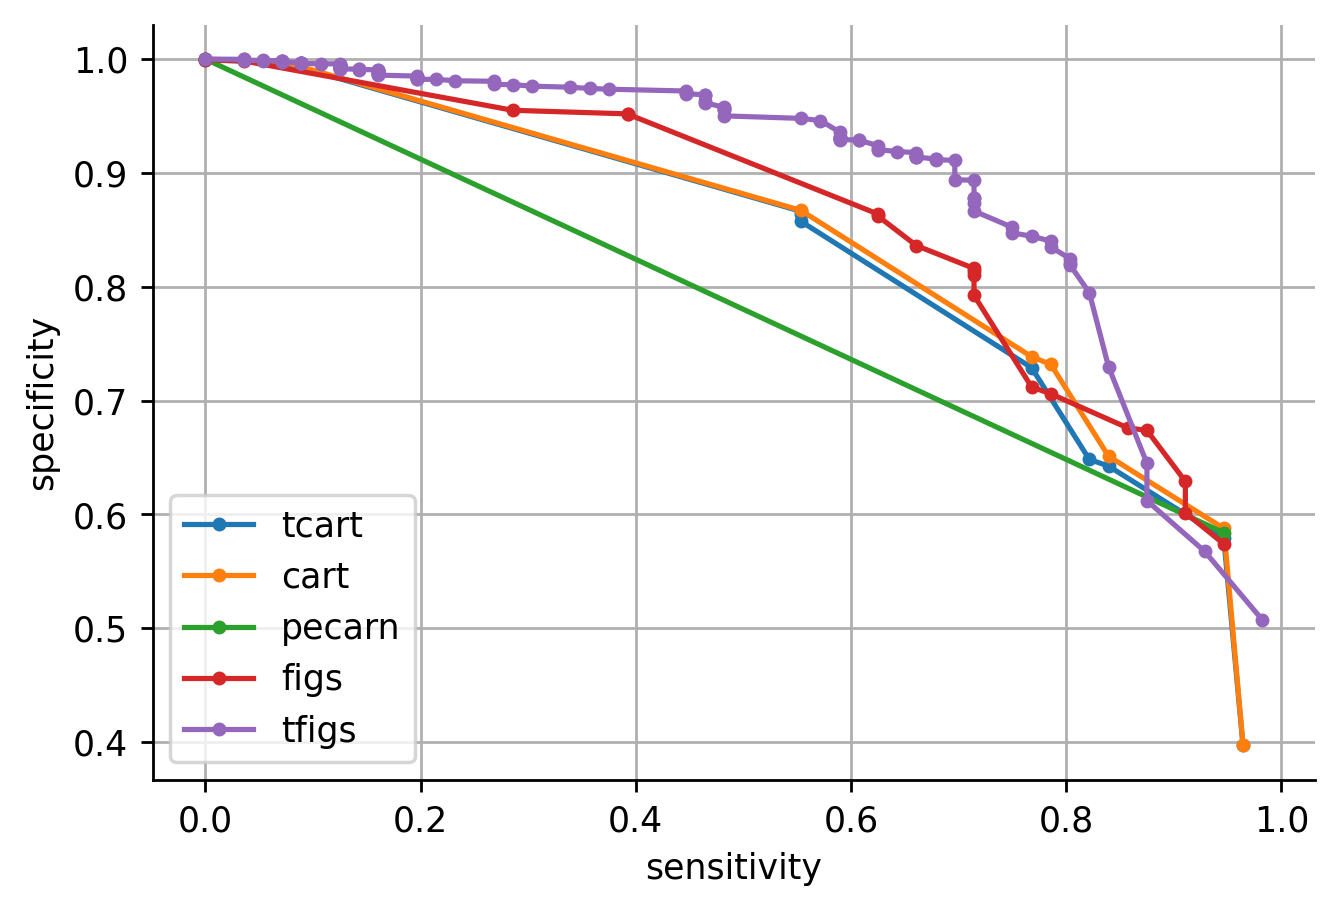

In [34]:
stats, threshes = predict_and_save(old_results.loc['TCART_>2_12_500', 'modelobj'], X_test_old, y_test_old, 'tcart')
stats, threshes = predict_and_save(old_results.loc['CART_>2_8_500', 'modelobj'], X_test_old, y_test_old, 'cart')
stats, threshes = predict_and_save(old_pecarn, X_test_old, y_test_old, 'pecarn')
stats, threshes = predict_and_save(old_results.loc['FIGS_>2_12_100', 'modelobj'], X_test_old.values, y_test_old, 'figs')
stats, threshes = predict_and_save(old_results.loc['TFIGS_>2_12_10', 'modelobj'], X_test_old.values, y_test_old, 'tfigs')
plt.legend()

100%|██████████| 35/35 [00:00<00:00, 163.64it/s]


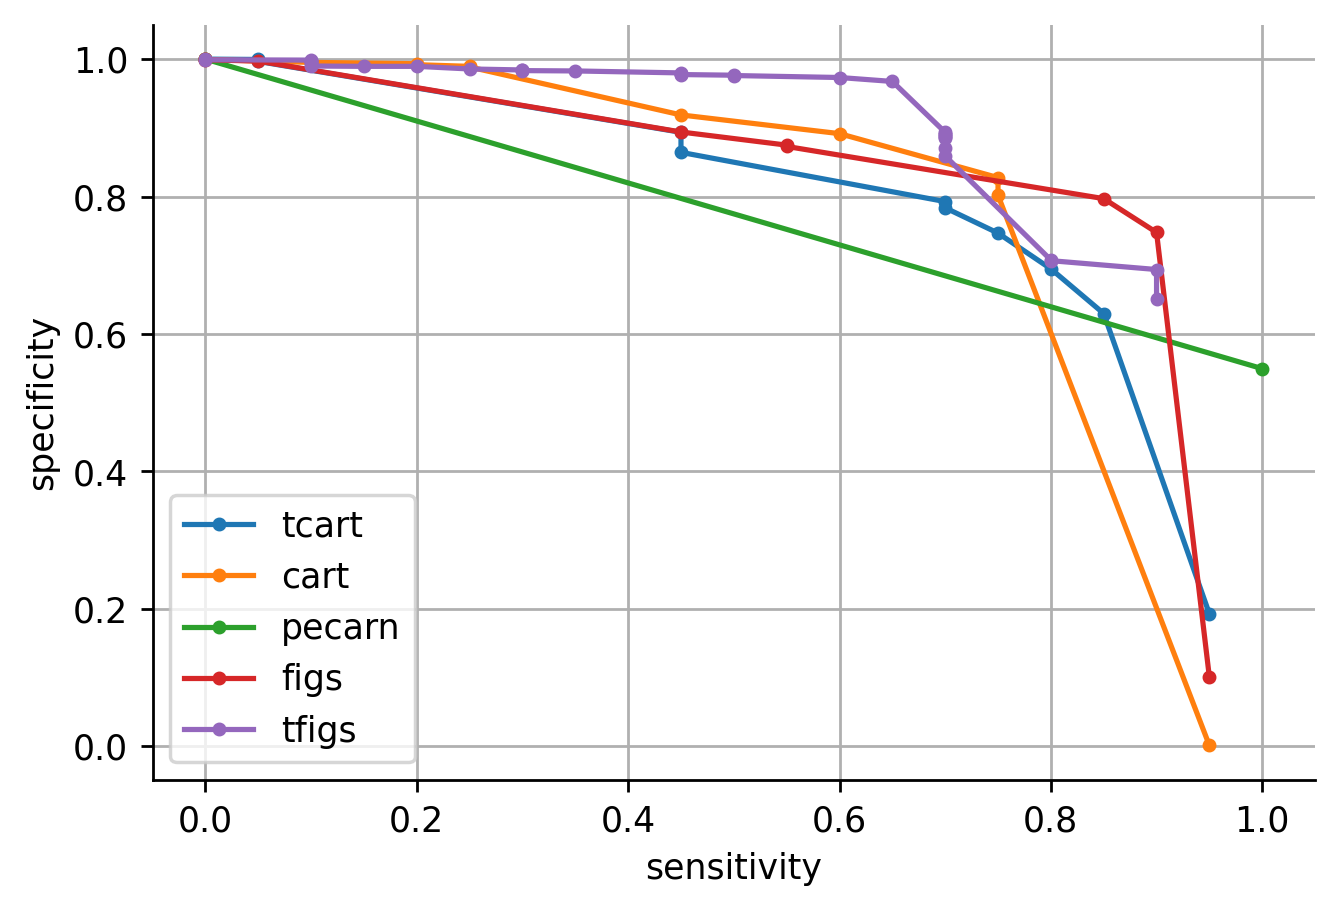

In [42]:
stats, threshes = predict_and_save(young_results.loc['TCART_<2_12_500', 'modelobj'], X_test_young, y_test_young, 'tcart')
stats, threshes = predict_and_save(young_results.loc['CART_<2_12_10', 'modelobj'],  X_test_young, y_test_young, 'cart')
stats, threshes = predict_and_save(young_pecarn, X_test_young, y_test_young, 'pecarn')
stats, threshes = predict_and_save(young_results.loc['FIGS_<2_8_100', 'modelobj'], X_test_young.values, y_test_young, 'figs')
stats, threshes = predict_and_save(young_results.loc['TFIGS_<2_8_10', 'modelobj'], X_test_young.values, y_test_young, 'tfigs')
plt.legend()

[Text(581.25, 701.0714285714286, 'AMS <= 0.5\ngini = 0.499\nsamples = 33942\nvalue = [8528.949, 7997.253]'),
 Text(435.9375, 593.2142857142858, 'SFxPalp_No <= 0.5\ngini = 0.417\nsamples = 29495\nvalue = [7588.058, 3200.833]'),
 Text(290.625, 485.35714285714283, 'gini = 0.262\nsamples = 631\nvalue = [202.073, 1100.572]'),
 Text(581.25, 485.35714285714283, 'HemaSize_Large <= 0.5\ngini = 0.345\nsamples = 28864\nvalue = [7385.984, 2100.26]'),
 Text(290.625, 377.5, 'SeizLen_Not applicable <= 0.5\ngini = 0.266\nsamples = 27139\nvalue = [6998.145, 1309.801]'),
 Text(145.3125, 269.6428571428571, 'gini = 0.345\nsamples = 231\nvalue = [58.604, 206.281]'),
 Text(435.9375, 269.6428571428571, 'High_impact_InjSev_High <= 0.5\ngini = 0.237\nsamples = 26908\nvalue = [6939.541, 1103.52]'),
 Text(290.625, 161.78571428571422, 'HemaLoc_Parietal/Temporal <= 0.5\ngini = 0.139\nsamples = 23151\nvalue = [5513.589, 448.971]'),
 Text(145.3125, 53.928571428571445, 'gini = 0.074\nsamples = 21294\nvalue = [5096.14

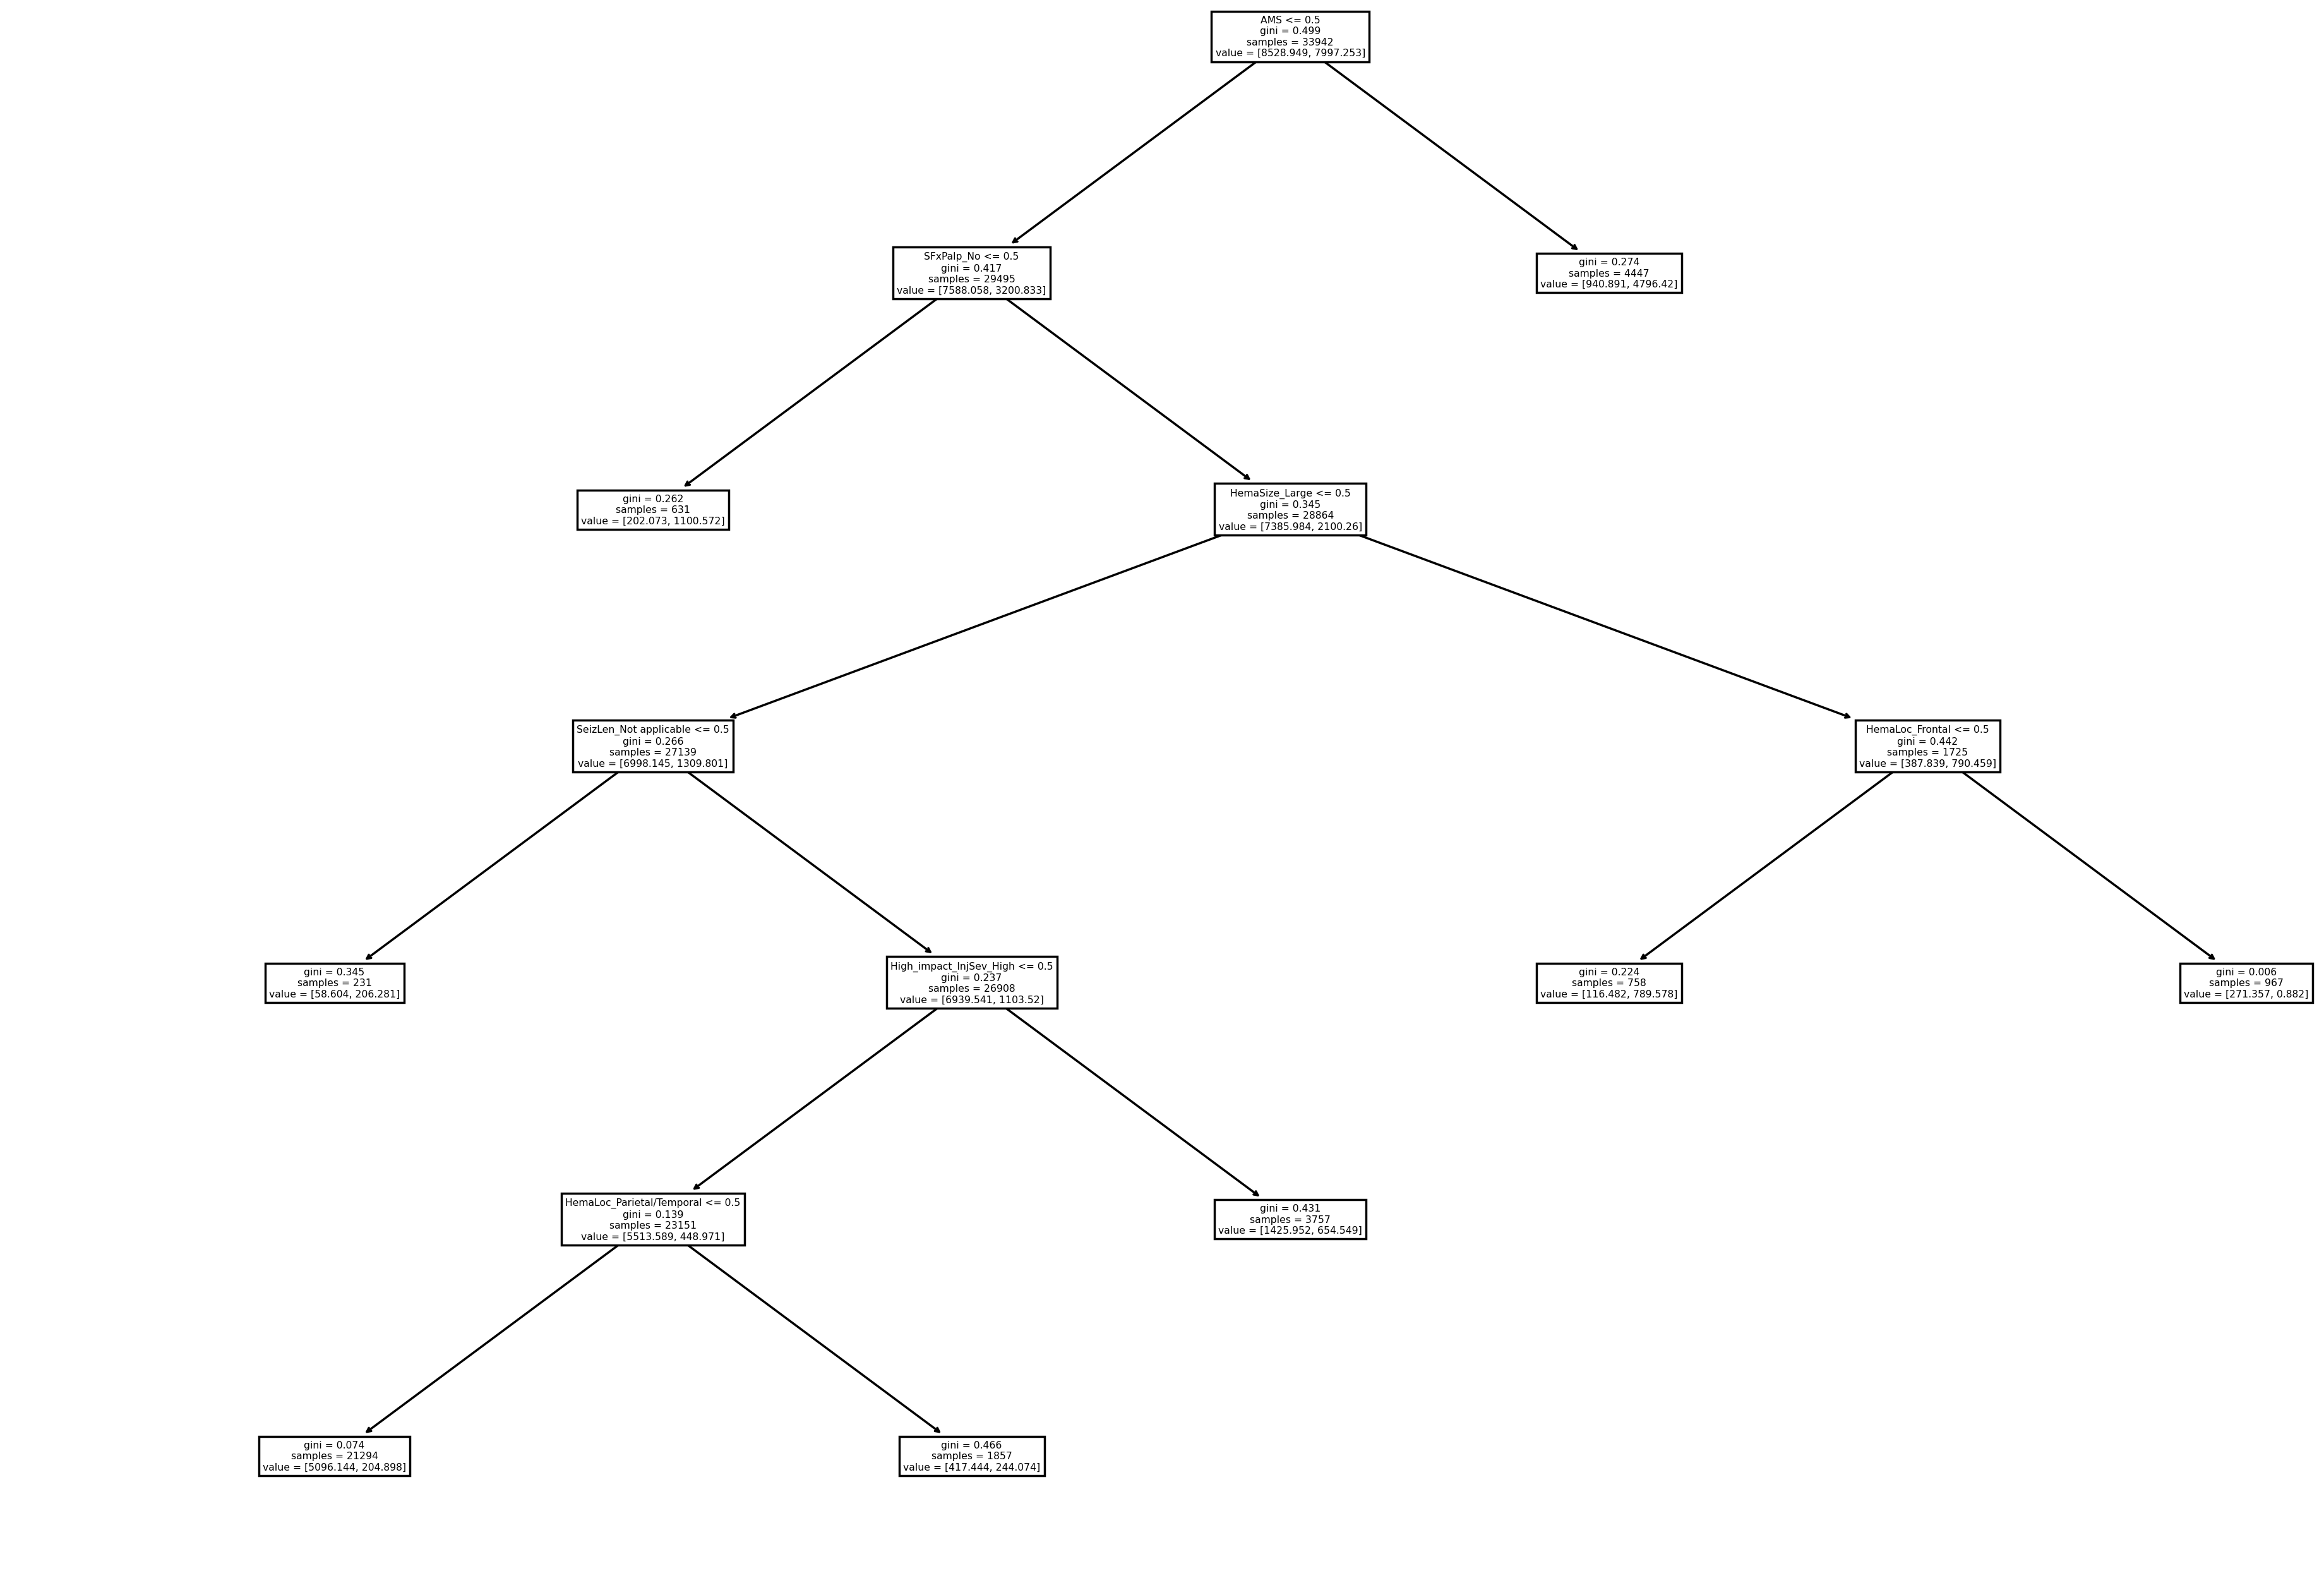

In [ ]:
plot_tree(young_tt, feature_names=feature_names)

### all results

### plain cart

In [ ]:
# cart = DecisionTreeClassifier(max_leaf_nodes=16, class_weight={0: 1, 1: 6})
# cart.fit(X_train, y_train)
# print_results(cart, X_test, y_test, age_groups_test)

spec:  0.004341534008683068
APC:  0.3850632074339372
AUC:  0.7852828289183916


In [ ]:
# stats, threshes = predict_and_save(cart, 'cart')
# plt.show()

### two trees, no transfer

In [ ]:
age_sample_weights_train = [(~is_group_1_train).astype(int), is_group_1_train.astype(int)]
subcart_no_transfer = TransferTree(2, **dtree_args)
subcart_no_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(subcart_no_transfer, X_test, y_test, age_groups_test)

spec:  0.06657018813314038
APC:  0.3720624712493928
AUC:  0.7714297699196712


In [ ]:
# plot_tree(subcart_no_transfer.trees[0], feature_names=feature_names)

In [ ]:
# plot_tree(subcart_no_transfer.trees[1], feature_names=feature_names)

### linear transfer

In [ ]:
age_sample_weights_train = [1 - p_group_1_train, p_group_1_train]
linear_transfer = TransferTree(2, **dtree_args)
linear_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(linear_transfer, X_test, y_test, age_groups_test)

spec:  0.060781476121562955
APC:  0.37001895934101336
AUC:  0.7855240252522074


### linear one-way transfer (higher -> lower)

In [ ]:
age_sample_weights_train = [1 - p_group_1_train, is_group_1_train.astype(int)]
linear_onew = TransferTree(2, **dtree_args)
linear_onew.fit(X_train, y_train, age_sample_weights_train)
print_results(linear_onew, X_test, y_test, age_groups_test)

spec:  0.060781476121562955
APC:  0.3761084875472075
AUC:  0.7868558484867552


### transfer using scores from non-age variables (predict group)

feature values are 0, 1, missing -> predict subgroup

propensity score

### density transfer

In [ ]:
# kde = KernelDensity()
# kde.fit(np.expand_dims(X_df['AgeInYears'].values, axis=1))
# np.exp(kde.score([[14]]))

<AxesSubplot:xlabel='AgeInYears', ylabel='Density'>

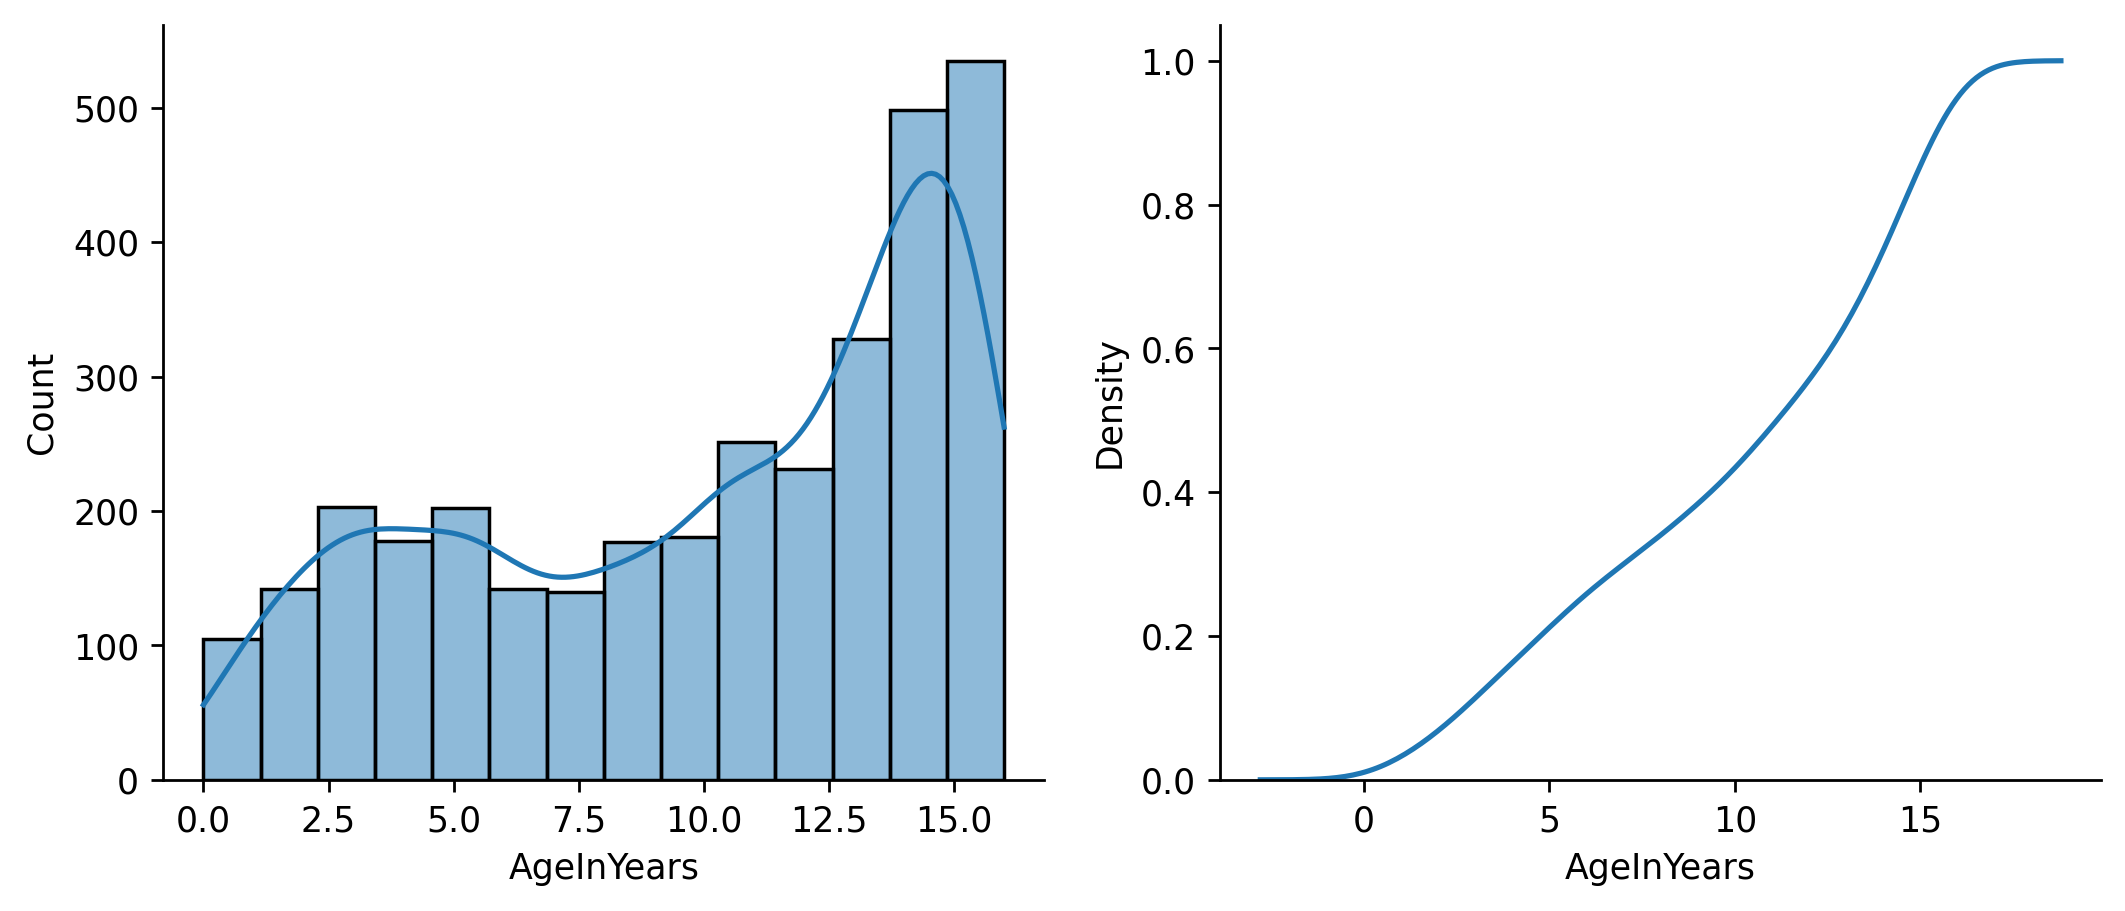

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(X_df['AgeInYears'], ax=axes[0], kde=True)
sns.kdeplot(X_df['AgeInYears'], cumulative=True, ax=axes[1])

In [ ]:
cdf_x, cdf_y = axes[1].lines[0].get_xdata(), axes[1].lines[0].get_ydata()
def kde_cdf(x):
    return cdf_y[np.searchsorted(cdf_x, x)]

In [ ]:
p_group_1_sig = X_df['AgeInYears'].apply(kde_cdf)
p_group_1_sig_train, p_group_1_sig_test = model_selection.train_test_split(
    p_group_1_sig, random_state=0)
age_sample_weights_train = [1 - p_group_1_sig_train, p_group_1_sig_train]

In [ ]:
kde_transfer = TransferTree(2, **dtree_args)
kde_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(kde_transfer, X_test, y_test, age_groups_test)

spec:  0.35021707670043417
APC:  0.37020158289499583
AUC:  0.7823727427169194


### sigmoidal transfer

In [ ]:
p_group_1_sig = 1 / (1 + np.exp(-5 * (X_df['AgeInYears'] - 7)))
p_group_1_sig_train, p_group_1_sig_test = model_selection.train_test_split(p_group_1_sig, random_state=0)
age_sample_weights_train = [1 - p_group_1_sig_train, p_group_1_sig_train]

In [ ]:
sig_transfer = TransferTree(2, **dtree_args)
sig_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(sig_transfer, X_test, y_test, age_groups_test)

spec:  0.060781476121562955
APC:  0.3691982184962685
AUC:  0.7819847312233897


### sigmoidal one-way transfer (higher -> lower)\

In [ ]:
age_sample_weights_train = [1 - p_group_1_sig_train, is_group_1_train.astype(int)]
sig_onew = TransferTree(2, **dtree_args)
sig_onew.fit(X_train, y_train, age_sample_weights_train)
print_results(sig_onew, X_test, y_test, age_groups_test)

spec:  0.060781476121562955
APC:  0.3764201996119569
AUC:  0.7849629816061577


### step transfer

In [ ]:
p_group_1_sig_train = is_group_1_train.astype(int) * 0.6
p_group_1_sig_train[p_group_1_sig_train == 0] = 0.4
age_sample_weights_train = [1 - p_group_1_sig_train, p_group_1_sig_train]

In [ ]:
step_transfer = TransferTree(2, **dtree_args)
step_transfer.fit(X_train, y_train, age_sample_weights_train)
print_results(step_transfer, X_test, y_test, age_groups_test)

spec:  0.060781476121562955
APC:  0.3830558418083852
AUC:  0.785413913882422


100%|██████████| 15/15 [00:00<00:00, 1860.55it/s]


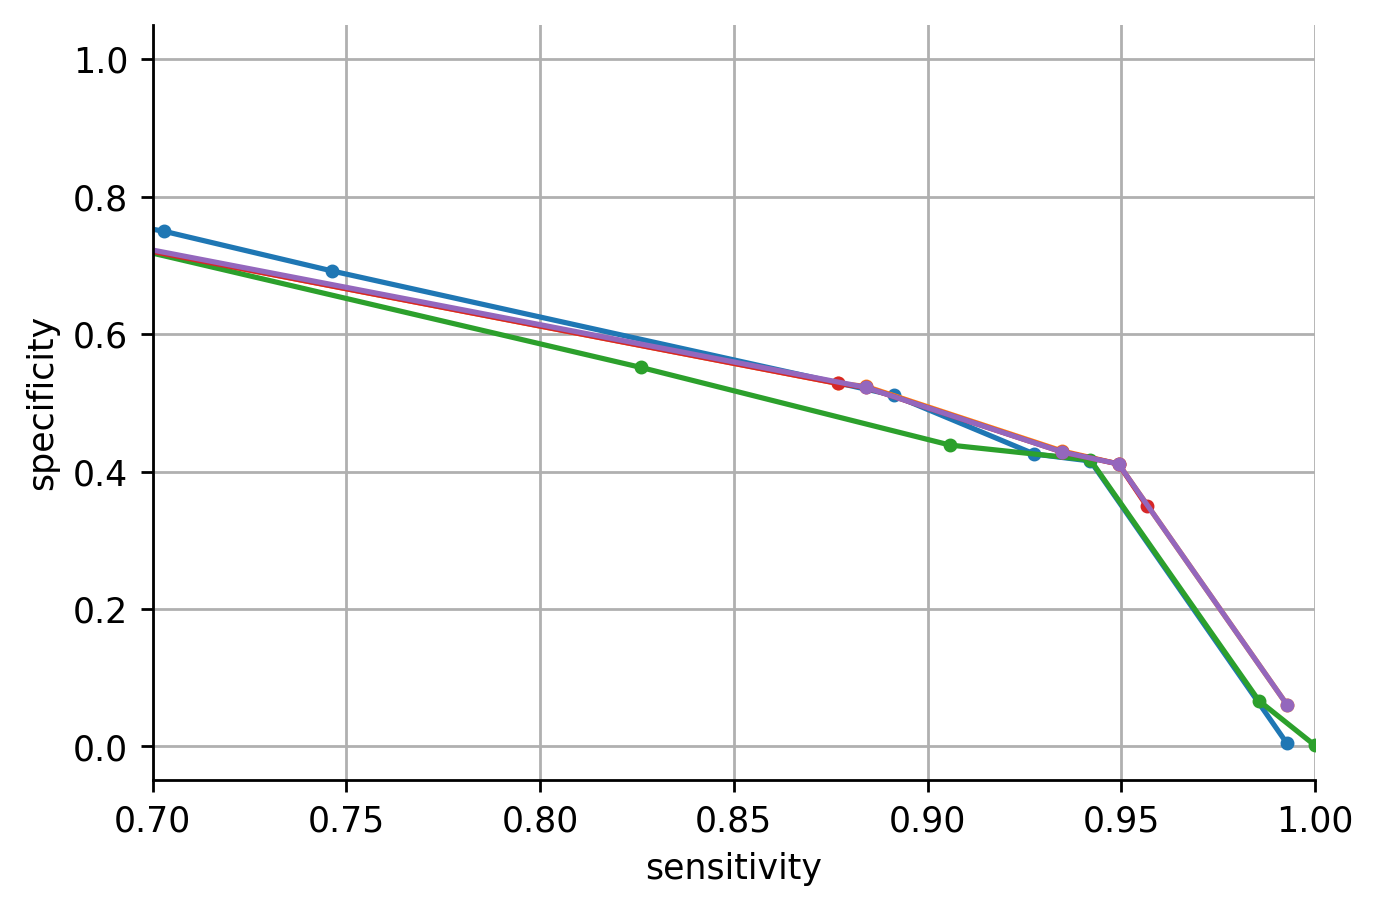

In [ ]:
stats, threshes = predict_and_save(cart, 'cart')
stats, threshes = predict_and_save(prop_transfer, 'prop-age', age_groups_test)
stats, threshes = predict_and_save(subcart_no_transfer, 'no_transfer', age_groups_test)
stats, threshes = predict_and_save(kde_transfer, 'kde_transfer', age_groups_test)
stats, threshes = predict_and_save(step_transfer, 'kde_transfer', age_groups_test)
plt.xlim(0.7, 1)
plt.show()

## site split

In [ ]:
n_sites = X_df['SITE'].unique().shape[0]
site_groups = [
    X_df['SITE'] == site for site in X_df['SITE'].sort_values().unique()]
site_groups_train, site_groups_test = zip(*[
    model_selection.train_test_split(group, random_state=2) for group in site_groups])
dtree_args['max_leaf_nodes'] = 4

In [ ]:
site_groups_nn_targets = sum([site_groups[i].astype(int) * (i + 1) for i in range(len(site_groups))])

In [ ]:
from sklearn.neural_network import MLPClassifier

prop_model = MLPClassifier((100, 100,), max_iter=500)
prop_model.fit(X_prop, site_groups_nn_targets)

/Users/keyan/anaconda3/envs/imodels-experiments/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500)

In [ ]:
all_prop_scores = prop_model.predict_proba(X_prop)
all_prop_scores_train, all_prop_scores_test = model_selection.train_test_split(all_prop_scores, random_state=2)

### plain cart

In [ ]:
cart = DecisionTreeClassifier(max_leaf_nodes=16, class_weight={0: 1, 1: 6}, random_state=0)
cart.fit(X_train, y_train)
print_results(cart, X_test, y_test, age_groups_test)

spec:  0.004341534008683068
APC:  0.3850632074339372
AUC:  0.7852828289183916


### propensity transfer

In [ ]:
site_sample_weights_train = [all_prop_scores_train[:, i] for i in range(n_sites)]
step_transfer = TransferTree(n_sites, **dtree_args)
step_transfer.fit(X_train, y_train, site_sample_weights_train)
print_results(step_transfer, X_test, y_test, site_groups_test)

spec:  0.20839363241678727
APC:  0.36283429681132984
AUC:  0.7358690408775352


### |sites| trees, no transfer

In [ ]:
site_sample_weights_train = [group.astype(int) for group in site_groups_train]
subcart_no_transfer = TransferTree(n_sites, **dtree_args)
subcart_no_transfer.fit(X_train, y_train, site_sample_weights_train)
print_results(subcart_no_transfer, X_test, y_test, site_groups_test)

spec:  0.08104196816208394
APC:  0.31733059551100673
AUC:  0.6948918811216678


### step transfer

In [ ]:
site_sample_weights_train = [group.astype(int).replace({0: 0.5}) for group in site_groups_train]
step_transfer = TransferTree(17, **dtree_args)
step_transfer.fit(X_train, y_train, site_sample_weights_train)
print_results(step_transfer, X_test, y_test, site_groups_test)

spec:  0.3921852387843705
APC:  0.3714990400734532
AUC:  0.7709368904549172


In [ ]:
ests = ['cart-16', 'prop-age', 'notransfer', 'linear', 'linear-oneway', 'kde', 'sigmoid', 'sigmoid-oneway',
        'step', 'cart-16-sites', 'prop-sites', 'notransfer-sites', 'step-sites']
pd.DataFrame(
    results_arr, columns=results_cols, index=ests).iloc[:-4].style.background_gradient()

,AUC,APC,Spec @ 95 sens
cart-16,0.785283,0.385063,0.004342
prop-age,0.785314,0.372598,0.060781
notransfer,0.771430,0.372062,0.066570
linear,0.785524,0.370019,0.060781
linear-oneway,0.786856,0.376108,0.060781
kde,0.782373,0.370202,0.350217
sigmoid,0.781985,0.369198,0.060781
sigmoid-oneway,0.784963,0.376420,0.060781
step,0.785414,0.383056,0.060781


In [ ]:
pd.DataFrame(
    results_arr, columns=results_cols, index=ests).iloc[-4:].style.background_gradient()

,AUC,APC,Spec @ 95 sens
cart-16-sites,0.785283,0.385063,0.004342
prop-sites,0.735869,0.362834,0.208394
notransfer-sites,0.694892,0.317331,0.081042
step-sites,0.770937,0.371499,0.392185


In [ ]:
X_df['SITE'].value_counts()

8.0     351
16.0    329
15.0    285
7.0     267
11.0    240
10.0    230
17.0    216
13.0    197
3.0     194
4.0     179
1.0     147
6.0     147
9.0     136
2.0     121
14.0    121
12.0     90
5.0      63
Name: SITE, dtype: int64